### Regression about the total power out of the large wave farm

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import sys
sys.path.append("..")
from bpitnorm.modules.BatchPitNormalization import BatchPitNorm1d

device = "cuda" if torch.cuda.is_available() else "cpu"

data = np.genfromtxt("../Data/waveEnergy.csv", delimiter=",", skip_header=1)
data = data[~(np.isnan(data)).any(axis=1)]
data = data[~(np.isinf(data)).any(axis=1)]
print("Number of features: ", data.shape[1])
print("Number of datapoints: ", data.shape[0])

def data_split(data):
  X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data[:, :-1], data[:, -1], test_size=0.2)
  y_train_raw = y_train_raw.reshape(-1, 1)
  y_test_raw = y_test_raw.reshape(-1, 1)

  scaler1 = StandardScaler()
  scaler_x = scaler1.fit(X_train_raw)
  X_train = scaler_x.transform(X_train_raw)
  X_test = scaler_x.transform(X_test_raw)

  scaler2 = StandardScaler()
  scaler_y = scaler2.fit(y_train_raw)
  y_train = scaler_y.transform(y_train_raw)
  y_test = scaler_y.transform(y_test_raw)

  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
  y_train = torch.tensor(y_train, dtype=torch.float32, device=device).reshape(-1, 1)
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device=device)
  y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device=device)
  return X_train, y_train, X_test, y_test, scaler_y

Number of features:  149
Number of datapoints:  36043


In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

def train_model(model, loops):
    model.to(device=device)
    r2score_lst = np.zeros(loops)
    meanAbsoluteError_lst = np.zeros(loops)
    torch.backends.cudnn.deterministic = True

    for i in range(loops):
        X_train, y_train, X_test, y_test, scaler_y = data_split(data)
        loss_fn = nn.MSELoss().to(device=device)
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=150, shuffle=True)
        n_epochs = 30
        for epoch in range(n_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device=device)
                y_batch = y_batch.to(device=device)
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward(retain_graph=True)
                optimizer.step()
                optimizer.zero_grad()
        
        model.eval()
        y_test_inverse = scaler_y.inverse_transform(y_test.cpu())
        y_pred = model(X_test)
        y_pred = scaler_y.inverse_transform(y_pred.cpu().detach().numpy())
        r2score = r2_score(y_test_inverse, y_pred)
        r2score_lst[i] = r2score
        meanAbsoluteError = mean_absolute_error(y_test_inverse, y_pred)
        meanAbsoluteError_lst[i] = meanAbsoluteError
    return r2score_lst, meanAbsoluteError_lst

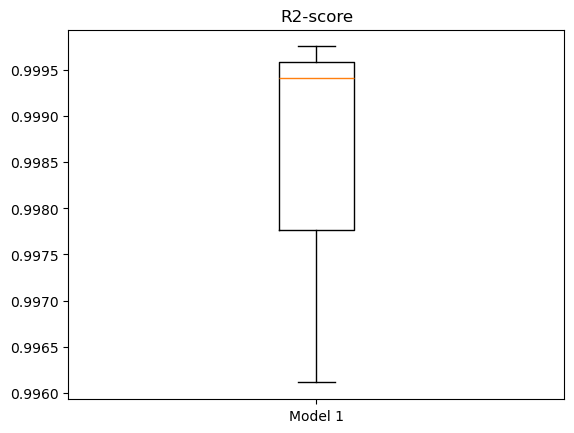

Mean of all total energies: 3938246.455667397


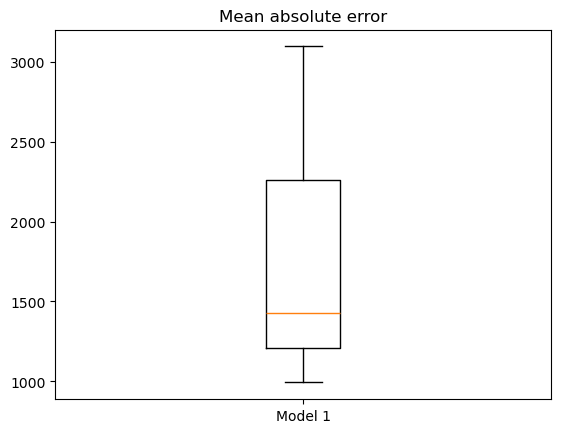

In [3]:
model1 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1))

model1.to(device=device)

r2Score1, MAE1 = train_model(model1, 3)
plt.boxplot(r2Score1, labels=["Model 1"])
plt.title("R2-score")
plt.show()
print(f"Mean of all total energies: {np.mean(data[:, -1])}")
plt.boxplot(MAE1, labels=["Model 1"])
plt.title("Mean absolute error")
plt.show()

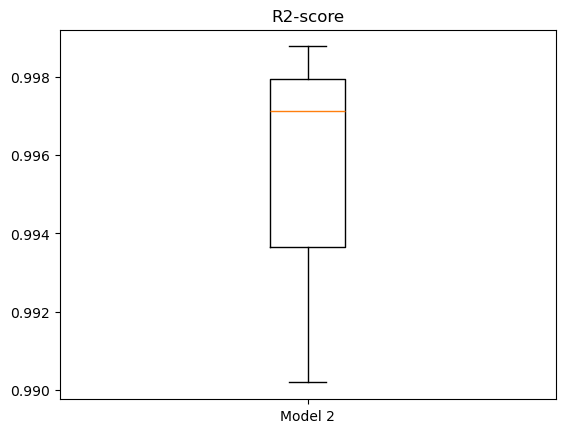

Mean of all total energies:  3938246.455667397


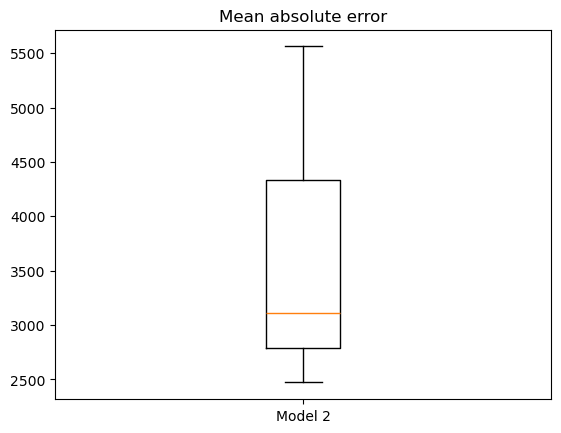

In [4]:
model2 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.BatchNorm1d(100),
    nn.Sigmoid(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1))

model2.to(device=device)

r2Score2, MAE2 = train_model(model2, 3)
plt.boxplot(r2Score2, labels=["Model 2"])
plt.title("R2-score")
plt.show()
print("Mean of all total energies: ", np.mean(data[:, -1]))
plt.boxplot(MAE2, labels=["Model 2"])
plt.title("Mean absolute error")
plt.show()

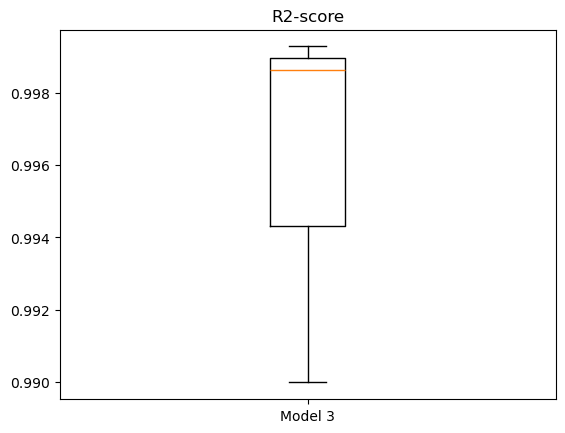

Mean of all total energies:  3938246.455667397


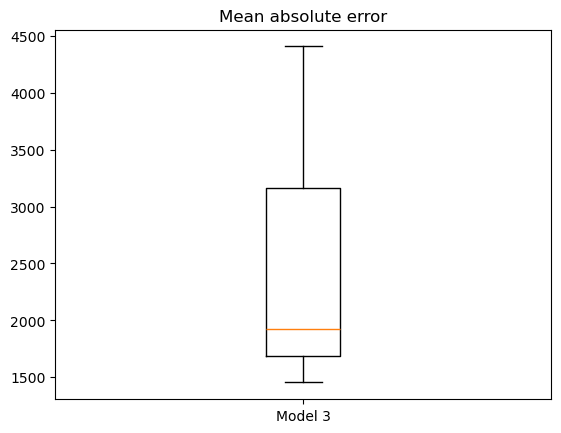

In [5]:
model3 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 30),
    BatchPitNorm1d(num_features=30, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.ReLU(),
    nn.Linear(30, 80),
    nn.ReLU(),
    nn.Linear(80, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1))
model3.to(device=device)

r2Score3, MAE3 = train_model(model3, 3)
plt.boxplot(r2Score3, labels=["Model 3"])
plt.title("R2-score")
plt.show()
print("Mean of all total energies: ", np.mean(data[:, -1]))
plt.boxplot(MAE3, labels=["Model 3"])
plt.title("Mean absolute error")
plt.show()

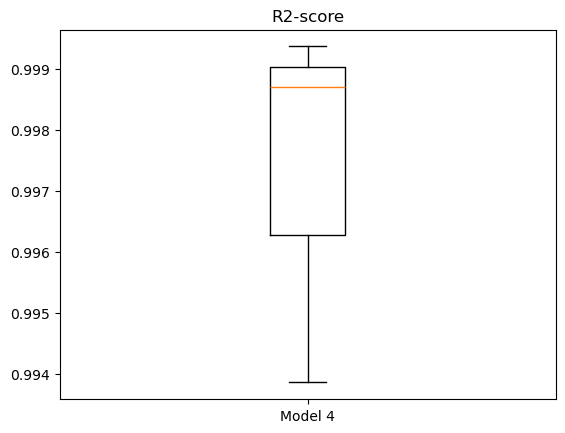

Mean of all total energies:  3938246.455667397


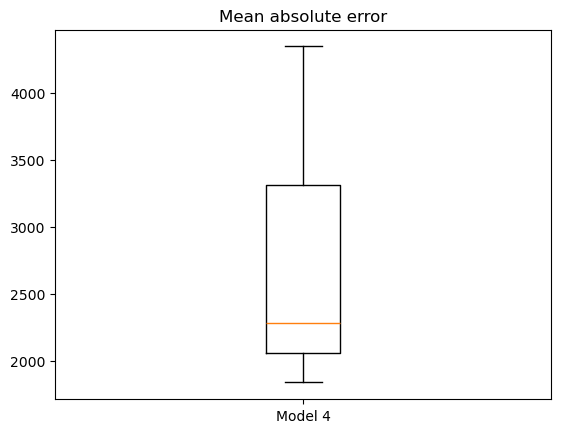

In [6]:
model4 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 30),
    nn.ReLU(),
    nn.Linear(30, 80),
    nn.ReLU(),
    nn.Linear(80, 10),
    BatchPitNorm1d(num_features=10, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.Sigmoid(),
    nn.Linear(10, 1))
model4.to(device=device)

r2Score4, MAE4 = train_model(model4, 3)
plt.boxplot(r2Score4, labels=["Model 4"])
plt.title("R2-score")
plt.show()
print("Mean of all total energies: ", np.mean(data[:, -1]))
plt.boxplot(MAE4, labels=["Model 4"])
plt.title("Mean absolute error")
plt.show()

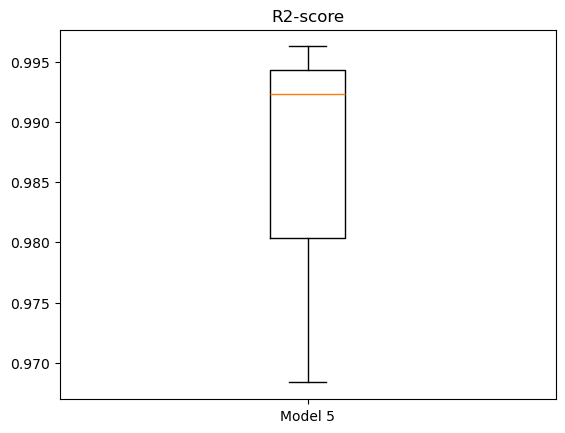

Mean of all total energies:  3938246.455667397


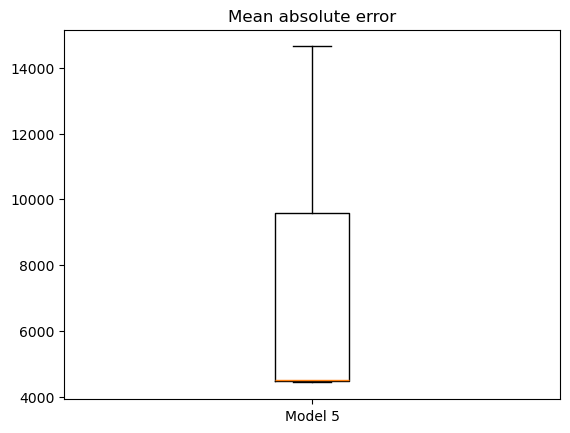

In [7]:
model5 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 30),
    BatchPitNorm1d(num_features=30, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.ReLU(),
    nn.Linear(30, 80),
    nn.ReLU(),
    nn.Linear(80, 10),
    nn.BatchNorm1d(10),
    nn.Sigmoid(),
    nn.Linear(10, 1))
model5.to(device=device)

r2Score5, MAE5 = train_model(model5, 3)
plt.boxplot(r2Score5, labels=["Model 5"])
plt.title("R2-score")
plt.show()
print("Mean of all total energies: ", np.mean(data[:, -1]))
plt.boxplot(MAE5, labels=["Model 5"])
plt.title("Mean absolute error")
plt.show()

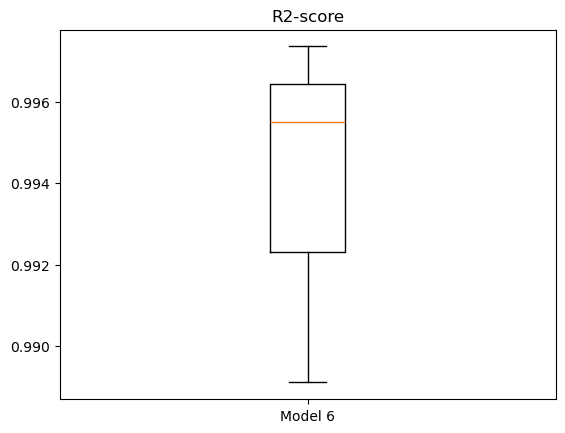

Mean of all total energies:  3938246.455667397


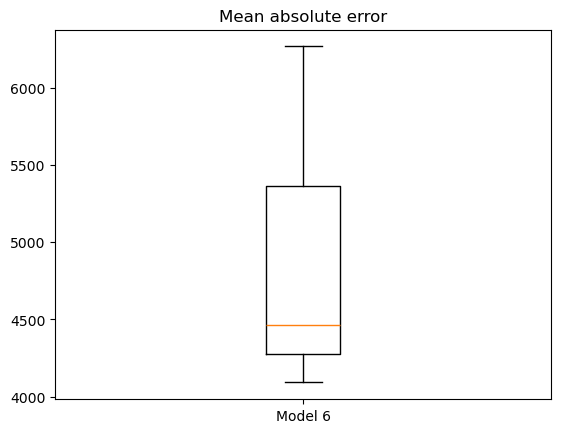

In [8]:
model6 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 30),
    nn.BatchNorm1d(30),
    nn.ReLU(),
    nn.Linear(30, 80),
    nn.ReLU(),
    nn.Linear(80, 10),
    BatchPitNorm1d(num_features=10, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.Sigmoid(),
    nn.Linear(10, 1))
model6.to(device=device)

r2Score6, MAE6 = train_model(model6, 3)
plt.boxplot(r2Score6, labels=["Model 6"])
plt.title("R2-score")
plt.show()
print("Mean of all total energies: ", np.mean(data[:, -1]))
plt.boxplot(MAE6, labels=["Model 6"])
plt.title("Mean absolute error")
plt.show()

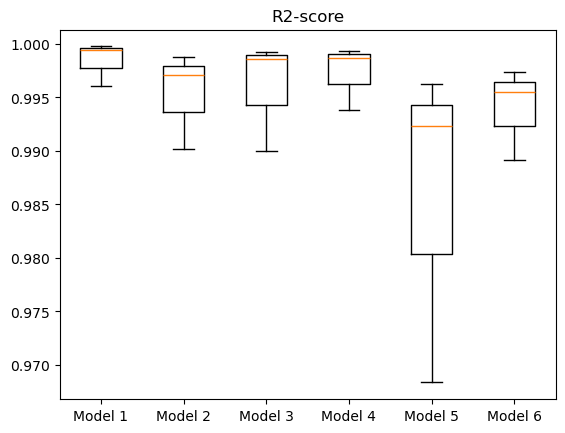

Mean shares of all news:  3938246.455667397


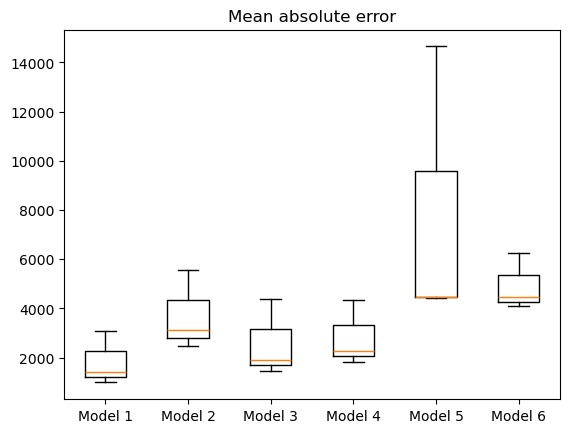

In [9]:
plt.boxplot([r2Score1, r2Score2, r2Score3, r2Score4, r2Score5, r2Score6], labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"])
plt.title("R2-score")
plt.show()
print("Mean shares of all news: ", np.mean(data[:, -1]))
plt.boxplot([MAE1, MAE2, MAE3, MAE4, MAE5, MAE6], labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"])
plt.title("Mean absolute error")
plt.show()

num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=2, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=2, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=3, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=3, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=5, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=5, normal_backtransfor

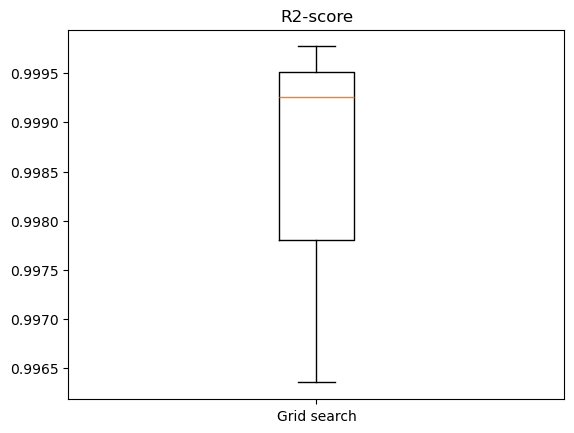

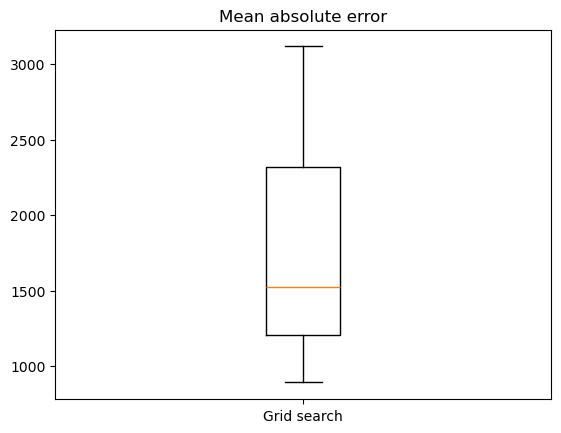

Best params: (100, 0, True, True) with MAE: 1844.4801477453473, R2-score: 0.9984598184826767


In [12]:
from itertools import product


param_grid = {
  'num_pit_samples': [50, 100, 150, 250, 500, 1000],
  'take_num_samples_when_full': [0, 1, 2, 3, 5, 10, 20],
  'normal_backtransform': [True, False],
  'trainable_bandwidths': [True, False]
}

best_MAE_g = np.inf
best_params = None

for params in product(*param_grid.values()):
  num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths = params

  if trainable_bandwidths == False:
    bw_select = "RuleOfThumb"
  else:
    bw_select = "ISJ"

  print(f"num_pit_samples={num_pit_samples}, take_num_samples_when_full={take_num_samples_when_full},"+
        f" normal_backtransform={normal_backtransform}, trainable_bandwidths={trainable_bandwidths}")

  # Same as model 4
  model_g = nn.Sequential(
    nn.Linear(data.shape[1]-1, 30),
    nn.ReLU(),
    nn.Linear(30, 80),
    nn.ReLU(),
    nn.Linear(80, 10),
    BatchPitNorm1d(num_features=10, num_pit_samples=num_pit_samples, take_num_samples_when_full=take_num_samples_when_full,
                    normal_backtransform=normal_backtransform, trainable_bandwidths=trainable_bandwidths, bw_select=bw_select, dev=device),
    nn.Sigmoid(),
    nn.Linear(10, 1))
  model_g.to(device=device)
  
  r2_g, MAE_g = train_model(model_g, 3)
  
  if np.mean(MAE_g) < np.mean(best_MAE_g):
    best_MAE_g = MAE_g
    best_r2_g = r2_g
    best_params = params

plt.boxplot(best_r2_g, labels=["Grid search"])
plt.title("R2-score")
plt.show()

plt.boxplot(best_MAE_g, labels=["Grid search"])
plt.title("Mean absolute error")
plt.show()

print(f"Best params: {best_params} with MAE: {np.mean(best_MAE_g)}, R2-score: {np.mean(best_r2_g)}")


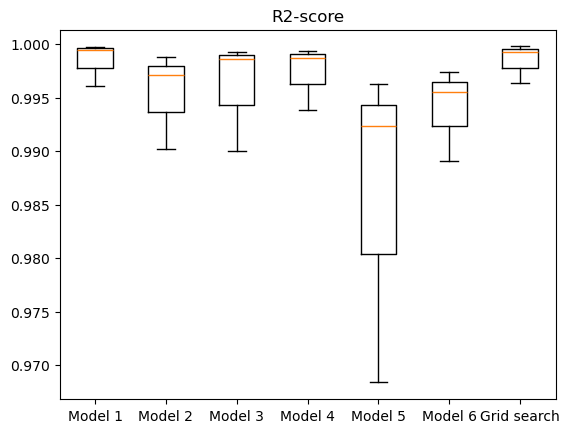

Mean of all total energies:  3938246.455667397


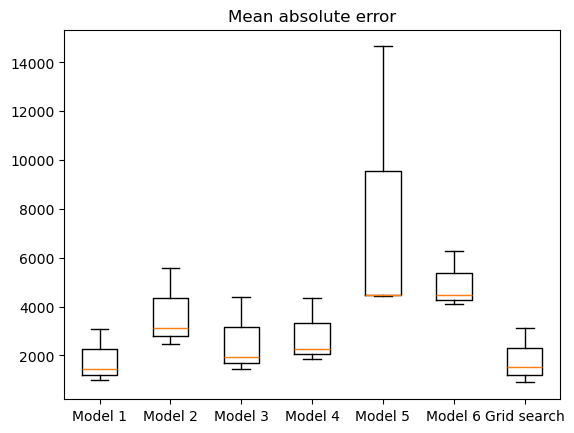

In [13]:
plt.boxplot([r2Score1, r2Score2, r2Score3, r2Score4, r2Score5, r2Score6, best_r2_g], labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6", "Grid search"])
plt.title("R2-score")
plt.show()
print("Mean of all total energies: ", np.mean(data[:, -1]))
plt.boxplot([MAE1, MAE2, MAE3, MAE4, MAE5, MAE6, best_MAE_g], labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6", "Grid search"])
plt.title("Mean absolute error")
plt.show()

Model 1: Without any batch layer 

Model 2: With ordinary batch normalization layer.

Model 3: With batch pit normalization layer.

Model 4: With batch pit normalization layer.

Model 5: With both ordinary batch and batch pit normalization layer.

Model 6: With both ordinary batch and batch pit normalization layer.

Very skillful models! High R2-scores and low mean absolute error compared to the mean of all total energies.